# Chapter 14 - Deep Computer Vision Using Convolutional Neural Networks
## Setup
First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale and RGB images:

In [32]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## What is a Convolution?

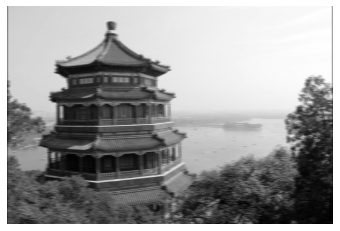

In [30]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

In [ ]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [ ]:
def crop(images):
    return images[150:220, 130:250]

In [ ]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

In [ ]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

### Convolutional Layer
Using ```keras.layers.Conv2D()```:

In [ ]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

In [ ]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

### VALID vs SAME padding

In [ ]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [ ]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [ ]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [ ]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

## Pooling layer
### Max pooling

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [ ]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

### Depth-wise pooling

In [ ]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [ ]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

Or just use a ```Lambda``` layer:

In [ ]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

### Average pooling

In [ ]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [ ]:
output_avg = avg_pool(cropped_images)

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### Global Average Pooling

In [ ]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

In [ ]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

## Tackling Fashion MNIST with a CNN

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

## ResNet-34

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

## Using a Pretrained Model

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

In [ ]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

In [ ]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

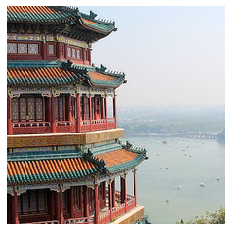

In [33]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

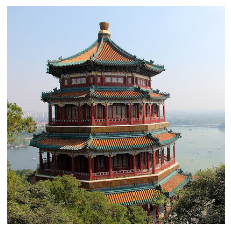

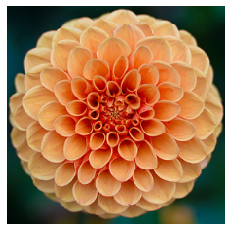

In [34]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [ ]:
Y_proba.shape

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

## Pretrained Models for Transfer Learning

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [ ]:
info.splits

In [ ]:
info.splits["train"]

In [ ]:
class_names = info.features["label"].names
class_names

In [ ]:
n_classes = info.features["label"].num_classes

In [ ]:
dataset_size = info.splits["train"].num_examples
dataset_size

**Warning:** TFDS's split API has evolved since the book was published. The [new split API](https://www.tensorflow.org/datasets/splits) (called S3) is much simpler to use:

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Basic preprocessing:

In [ ]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Slightly fancier preprocessing (but you could add much more data augmentation):

In [ ]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

## Classification and Localization

In [23]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [24]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [25]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 22s 4s/step - loss: 1.2941 - dense_6_loss: 1.5347 - dense_7_loss: 0.3318 - dense_6_accuracy: 0.2969 - dense_7_accuracy: 0.2744
Epoch 2/2
5/5 [==============================] - 19s 4s/step - loss: 1.1331 - dense_6_loss: 1.3631 - dense_7_loss: 0.2132 - dense_6_accuracy: 0.5107 - dense_7_accuracy: 0.2303


### Mean Average Precision (mAP)

In [26]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

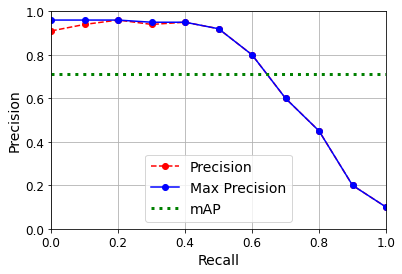

In [27]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

Transpose convolutions:

In [35]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

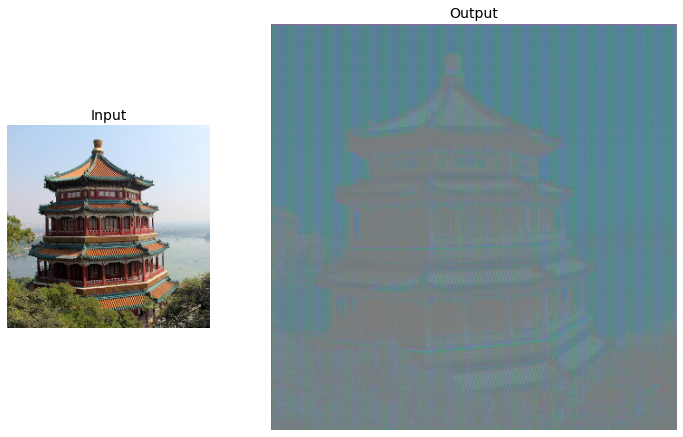

In [36]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [37]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [38]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

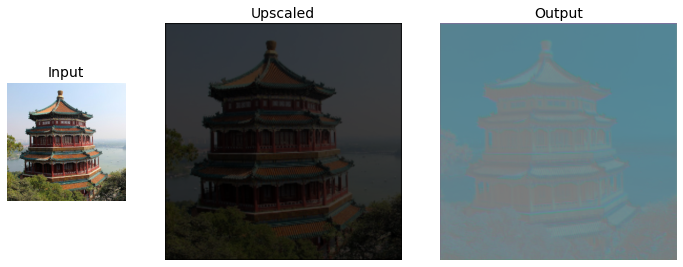

In [39]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()

In [40]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True

## Exercises
### 9. High Accuracy CNN for MNIST
*Exercise: Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST.*

The following model uses 2 convolutional layers, followed by 1 pooling layer, then dropout 25%, then a dense layer, another dropout layer but with 50% dropout, and finally the output layer. It reaches about 99.2% accuracy on the test set. This places this model roughly in the top 20% in the [MNIST Kaggle competition](https://www.kaggle.com/c/digit-recognizer/) (if we ignore the models with an accuracy greater than 99.79% which were most likely trained on the test set, as explained by Chris Deotte in [this post](https://www.kaggle.com/c/digit-recognizer/discussion/61480)). Can you do better? To reach 99.5 to 99.7% accuracy on the test set, you need to add image augmentation, batch norm, use a learning schedule such as 1-cycle, and possibly create an ensemble.

In [41]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [42]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 40s 23ms/step - loss: 0.3740 - accuracy: 0.8830 - val_loss: 0.0463 - val_accuracy: 0.9874
Epoch 2/10
1719/1719 [==============================] - 39s 23ms/step - loss: 0.0817 - accuracy: 0.9755 - val_loss: 0.0378 - val_accuracy: 0.9898
Epoch 3/10
1719/1719 [==============================] - 40s 24ms/step - loss: 0.0578 - accuracy: 0.9813 - val_loss: 0.0375 - val_accuracy: 0.9892
Epoch 4/10
1719/1719 [==============================] - 40s 23ms/step - loss: 0.0499 - accuracy: 0.9840 - val_loss: 0.0324 - val_accuracy: 0.9924
Epoch 5/10
1719/1719 [==============================] - 39s 23ms/step - loss: 0.0406 - accuracy: 0.9877 - val_loss: 0.0309 - val_accuracy: 0.9920
Epoch 6/10
1719/1719 [==============================] - 40s 23ms/step - loss: 0.0359 - accuracy: 0.9889 - val_loss: 0.0381 - val_accuracy: 0.9894
Epoch 7/10
1719/1719 [==============================] - 40s 23ms/step - loss: 0.0341 - accuracy: 0.9896 - val_loss: 0.0369 -

[0.02970757521688938, 0.9923999905586243]